In [2]:
import datetime

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py

### Reading Data

In [52]:
with h5py.File('../Data/Binance.h5') as file:
    data = file.get('BTCUSDT')
    data_array = np.array(data)
    df = pd.DataFrame(data_array, columns=('timestamp', 'open', 'high', 'low', 'close', 'volume'))

    file.close()

df.head()

,timestamp,open,high,low,close,volume
0,1.721161e+12,65130.8,65130.8,65072.3,65113.8,149.297
1,1.721161e+12,65113.8,65113.9,65001.6,65058.4,115.384
2,1.721161e+12,65058.5,65073.9,64932.0,64946.7,230.388
3,1.721161e+12,64946.7,64960.0,64860.1,64926.3,264.300
4,1.721161e+12,64926.3,64985.0,64904.1,64985.0,80.128


### Date preprocessing 


In [53]:
df.sort_values(by='timestamp', inplace = True)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)
df.head()

,open,high,low,close,volume
timestamp,,,,,
2024-06-26 00:18:00,61751.9,61774.0,61751.9,61752.4,24.654
2024-06-26 00:19:00,61752.4,61758.7,61752.4,61756.4,25.549
2024-06-26 00:20:00,61756.4,61772.7,61753.5,61754.6,25.185
2024-06-26 00:21:00,61756.4,61773.2,61756.4,61758.1,10.424
2024-06-26 00:22:00,61758.0,61768.0,61752.2,61756.9,34.291


## Calculating VWAP

In [54]:
df['price'] = (df['close'] + df['low'] + df['high']) / 3

In [55]:
df['date'] = df.index.date

In [56]:
df['volume_period'] = df.groupby(by=df.index.date)['volume'].sum()

In [57]:
# forward fill to identify the dates that are incomplete
df['volume_period'] = df['volume_period'].ffill()

# The NaN values remaining are dates that are incomplete
df.dropna(inplace=True)
df.drop('date', axis = 1, inplace=True)

In [58]:
df['price_volume'] = df['price'] * df['volume']

In [59]:
df['VWAP'] = (df['price_volume'].cumsum()) / df['volume_period']

In [60]:
df.head()

,open,high,low,close,volume,price,volume_period,price_volume,VWAP
timestamp,,,,,,,,,
2024-06-27 00:00:00,60860.1,60870.0,60833.5,60835.1,68.927,60846.200000,160172.482,4.193946e+06,26.183936
2024-06-27 00:01:00,60835.2,60835.2,60809.8,60809.8,43.844,60818.266667,160172.482,2.666516e+06,42.831715
2024-06-27 00:02:00,60809.9,60822.5,60804.6,60813.4,93.540,60813.500000,160172.482,5.688495e+06,78.346522
2024-06-27 00:03:00,60813.4,60887.1,60813.4,60885.9,69.652,60862.133333,160172.482,4.239169e+06,104.812799
2024-06-27 00:04:00,60885.8,60899.6,60861.6,60867.5,266.464,60876.233333,160172.482,1.622132e+07,206.086904


#### Calculating the standard deviation lines


In [61]:
df['variance'] = (((df['price'] - df['VWAP'])** 2) * df['volume']).cumsum()

In [62]:
df['off'] = np.sqrt(df['variance'] / df['volume_period'])

#### This will be how the lines of STD will be drawn on a graph
    

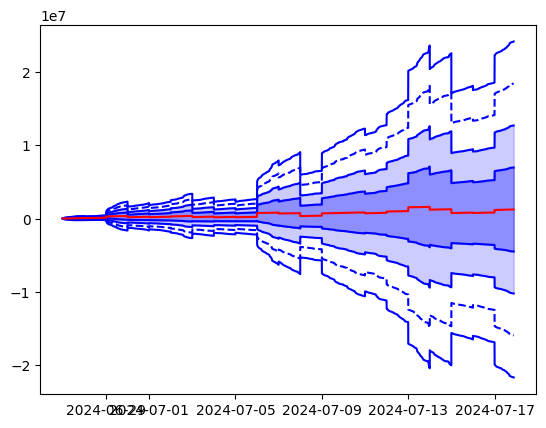

In [63]:
# TB represents Top band
# BB represents Bottom band

plt.plot(df.index, (df['VWAP'] + 1.96 * df['off']),  label='TB1', color='b')
plt.plot(df.index, (df['VWAP'] - 1.96 * df['off']),  label='BB1', color='b')
plt.fill_between(df.index, (df['VWAP'] + 1.96 * df['off']), (df['VWAP'] - 1.96 * df['off']),
                 color='b', alpha=0.3)

plt.plot(df.index, (df['VWAP'] + 2 * 1.96 * df['off']),  label='TB2', color='b')
plt.plot(df.index, (df['VWAP'] - 2 * 1.96 * df['off']),  label='BB2', color='b')
plt.fill_between(df.index, (df['VWAP'] + 2 * 1.96 * df['off']), (df['VWAP'] - 2 * 1.96 * df['off']),
                 color='b', alpha=0.2)

plt.plot(df.index, (df['VWAP'] + 3 * 1.96 * df['off']),  label='TB3', color='b', linestyle= '--')
plt.plot(df.index, (df['VWAP'] - 3 * 1.96 * df['off']),  label='BB3', color='b', linestyle= '--')

plt.plot(df.index, (df['VWAP'] + 4 * 1.96 * df['off']),  label='TB4', color='b')
plt.plot(df.index, (df['VWAP'] - 4 * 1.96 * df['off']),  label='BB4', color='b')

plt.plot(df.index, df['VWAP'] ,  label='POC', color='r')
# plt.legend()

In [30]:
# The irregularities of the graph are due to the fact that the data contains a 30-day period, 
# and the graph shows the daily VWAPs (Volume Weighted Average Prices) for each day